In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# needs 1.12 for mixup to work
# !pip install tensorflow=="1.15"

import tensorflow as tf
print(tf.__version__)
from PIL import Image
import glob
import numpy as np
import random
from keras.utils import Sequence
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import backend as K
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import load_model

1.15.0



# Iterate through the photos and resize the images as 256 x 256 images



In [0]:
def reshape_photos(photos, size, path, newFolder, imgBaseName):
  i = 1
  for photo in photos:
    im = Image.open(photo)
    im = im.resize((size, size))

    im2 = im
    im.save(path + newFolder + imgBaseName + str(i) + '.png', 'PNG')
    i += 1

    im2 = im2.transpose(Image.FLIP_LEFT_RIGHT)
    im2.save(path + newFolder + imgBaseName + str(i) + '.png', 'PNG')
    i += 1

    im3 = im2.rotate(random.randint(-15, 15))
    im3.save(path + newFolder + imgBaseName + str(i) + '.png', 'PNG')
    
    i += 1


In [0]:
def make_photos():
  path = '/content/gdrive/My Drive/867Project/ProjectData/'
  shots = 'ShotsNew/*.png'
  no_shots = 'NoShotsNew/*.png'

  shot_imgs = glob.glob(path + shots)
  no_shot_img = glob.glob(path + no_shots)
  print(len(shot_imgs), len(no_shot_img))

  reshape_photos(shot_imgs, 32, path, 'shotEdit32/', 'img_')
  reshape_photos(no_shot_img, 32, path, 'noShotEdit32/', 'img_')

make_photos()

149 126


# Create training and testing arrays

In [0]:
def load_images(path, folder1, folder2):
  img_shot = glob.glob(path + folder1 + "*.png")
  img_no_shot = glob.glob(path + folder2 + "*.png")
  print("Shot images to no shot images: {}, {}".format(len(img_shot), len(img_no_shot)))
  
  # load all of the images with the labeling
  combined = []
  for img in img_shot:
    im = Image.open(img)
    im = np.array(im)
    im = im[:,:,:3]/255.
    combined.append(np.array([im, 1]))

  for img2 in img_no_shot:
    im2 = Image.open(img2)
    im2 = np.array(im2)
    im2 = im2[:,:,:3]/255.
    combined.append(np.array([im2, 0]))
    
  combined = np.array(combined)
  np.random.shuffle(combined)
  print(combined.shape)
  x1 = combined[:,0]
  x = np.array([x_1 for x_1 in x1])
  y = combined[:,1:]
  print(x.shape)

  # split into train, valid, test (6, 2, 2)
  split1 = int(3*len(combined)/5.)
  split2 = int(4*len(combined)/5.)
  return (x[:split1], x[split1:split2], x[split2:], y[:split1], y[split1:split2], y[split2:])
  
  
path = '/content/gdrive/My Drive/867Project/ProjectData/'
# x_train, x_valid, x_test, y_train, y_valid, y_test = load_images(path, "shotEdit256/", "noShotEdit256/")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_images(path, "shotEdit32/", "noShotEdit32/")  

Shot images to no shot images: 447, 378
(825, 2)
(825, 32, 32, 3)


In [0]:
print("x and y shapes \n{} \n{} \n{} \n{} \n{}\n{}".format(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape))
y_list = [y_train, y_valid, y_test]
print("values and counts")
for y in y_list:
  unique, counts = np.unique(y, return_counts=True)
  print(np.asarray((unique, counts)).T)

x and y shapes 
(495, 32, 32, 3) 
(495, 1) 
(165, 32, 32, 3) 
(165, 1) 
(165, 32, 32, 3)
(165, 1)
values and counts
[[0 235]
 [1 260]]
[[0 70]
 [1 95]]
[[0 73]
 [1 92]]


#**Create the model to train**

In [0]:
def make_model(shape):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(shape, shape, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (2, 2), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  return model


In [0]:
model = make_model(32)

NameError: ignored

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

history = model.fit(x_train, y_train, epochs=20, 
                    validation_data=(x_valid, y_valid))


Train on 495 samples, validate on 165 samples
Epoch 1/20
495/495 [==============================] - 0s 858us/sample - loss: 0.6956 - auc_2: 0.4777 - val_loss: 0.6857 - val_auc_2: 0.6016
Epoch 2/20
495/495 [==============================] - 0s 190us/sample - loss: 0.6929 - auc_2: 0.4972 - val_loss: 0.6870 - val_auc_2: 0.7476
Epoch 3/20
495/495 [==============================] - 0s 190us/sample - loss: 0.6836 - auc_2: 0.5769 - val_loss: 0.6807 - val_auc_2: 0.7793
Epoch 4/20
495/495 [==============================] - 0s 182us/sample - loss: 0.6742 - auc_2: 0.5990 - val_loss: 0.6589 - val_auc_2: 0.8056
Epoch 5/20
495/495 [==============================] - 0s 188us/sample - loss: 0.6293 - auc_2: 0.7251 - val_loss: 0.5982 - val_auc_2: 0.8216
Epoch 6/20
495/495 [==============================] - 0s 202us/sample - loss: 0.6144 - auc_2: 0.7120 - val_loss: 0.5896 - val_auc_2: 0.8241
Epoch 7/20
495/495 [==============================] - 0s 196us/sample - loss: 0.5923 - auc_2: 0.7615 - val_loss: 0

In [0]:
# Score trained model.
print(len(x_test))
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test auc:', scores[1])

165
165/165 [==============================] - 0s 143us/sample - loss: 0.3524 - auc_2: 0.9447
Test loss: 0.35242477312232506
Test auc: 0.94473845


In [0]:
model.save('/content/gdrive/My Drive/867Project/model.h5')

In [0]:
# model = load_model('/content/gdrive/My Drive/867Project/model.h5')
p = model.predict(x_test)
q = model.predict_classes(x_test)
for pred, cla in zip(p,q):
  print(pred, cla)

[0.6190082] [1]
[0.2727449] [0]
[0.971717] [1]
[0.24543002] [0]
[0.8319015] [1]
[0.16103914] [0]
[0.3254785] [0]
[0.3031258] [0]
[0.34872794] [0]
[0.40412486] [0]
[0.13445485] [0]
[0.29587245] [0]
[0.9665353] [1]
[0.2243335] [0]
[0.92411935] [1]
[0.17310247] [0]
[0.94167435] [1]
[0.9959223] [1]
[0.14107442] [0]
[0.45506656] [0]
[0.2210576] [0]
[0.99742687] [1]
[0.91736364] [1]
[0.6722871] [1]
[0.98444915] [1]
[0.11531615] [0]
[0.36253136] [0]
[0.70532995] [1]
[0.98940325] [1]
[0.16767189] [0]
[0.12590903] [0]
[0.28405923] [0]
[0.7248693] [1]
[0.5578762] [1]
[0.09853062] [0]
[0.11364472] [0]
[0.9737261] [1]
[0.8821371] [1]
[0.9765115] [1]
[0.32790458] [0]
[0.9353106] [1]
[0.9442693] [1]
[0.1307376] [0]
[0.0786365] [0]
[0.4192056] [0]
[0.17305335] [0]
[0.16047356] [0]
[0.34621125] [0]
[0.2596429] [0]
[0.12362784] [0]
[0.20045987] [0]
[0.98348975] [1]
[0.23138309] [0]
[0.1326065] [0]
[0.200077] [0]
[0.08530927] [0]
[0.3185501] [0]
[0.8980172] [1]
[0.99457824] [1]
[0.2070801] [0]
[0.550538

#**MIX UP Implementation**


In [0]:
def make_dataframe():
  folder1 = "shotEdit32/"
  folder2 = "noShotEdit32/"
  img_shot = glob.glob(path + folder1 + "*.png")
  img_no_shot = glob.glob(path + folder2 + "*.png")
  df = pd.DataFrame(columns=["path", "class"])
  for i in img_shot:
    df = df.append({"path": i, "class": '1'}, ignore_index=True)
  for j in img_no_shot:
    df = df.append({"path": j, "class": '0'}, ignore_index=True)
  df = df.sample(frac=1).reset_index(drop=True)
  print(set(df['class'].tolist()))
  test = int(0.8*len(df))
  return df[:test], df[test:] 

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [0]:
class MixupImageDataGenerator():
    def __init__(self, generator, dataframe, batch_size, img_height, img_width, alpha=0.5, subset=None):
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_dataframe(dataframe,
                                                        target_size=(
                                                            img_height, img_width),
                                                        x_col='path',
                                                        y_col='class',
                                                        batch_size=batch_size,
                                                        class_mode="binary",
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_dataframe(dataframe,
                                                        target_size=(
                                                            img_height, img_width),
                                                        x_col='path',
                                                        y_col='class',
                                                        class_mode="binary",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return (X, y)

    def __iter__(self):
        while True:
            yield next(self)

In [0]:
path = '/content/gdrive/My Drive/867Project/ProjectData/'
in_dataframe, test_dataframe = make_dataframe()

batch_size = 1
validation_split = 0.2
img_height = 32
img_width = 32
epochs = 20

# Optional additional image augmentation with ImageDataGenerator.
input_imgen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0,
    shear_range=0.05,
    zoom_range=0,
    brightness_range=(1, 1.3),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split)

# input_imgen_test = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=5,
#     width_shift_range=0.05,
#     height_shift_range=0,
#     shear_range=0.05,
#     zoom_range=0,
#     brightness_range=(1, 1.3),
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0)

# # Create training and validation generator.
train_generator = MixupImageDataGenerator(generator=input_imgen,
                                          dataframe=in_dataframe,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height,
                                          subset='training')
validation_generator = input_imgen.flow_from_dataframe(in_dataframe,
                                                       target_size=(
                                                           img_height, img_width),
                                                        x_col='path',
                                                        y_col='class',
                                                       class_mode="binary",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset='validation')

# test_generator = input_imgen.flow_from_dataframe(test_dataframe,
#                                                        target_size=(
#                                                            img_height, img_width),
#                                                         x_col='path',
#                                                         y_col='class',
#                                                        class_mode="binary",
#                                                        batch_size=batch_size,
#                                                        shuffle=True)

print('training steps: ', train_generator.get_steps_per_epoch())
print('validation steps: ', validation_generator.samples // batch_size)

# auc = tf.contrib.metrics.streaming_auc(a, b)

# Build a Keras image classification model as usual.
model = make_model(32)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[auc])

# # Start the traning.
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.get_steps_per_epoch(),
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs)

{'0', '1'}
Found 528 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
training steps:  528
validation steps:  132
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 31, 32)        416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_______________________________________

In [0]:
sample_x, sample_y = next(train_generator)
for i in range(batch_size):
    display(image.array_to_img(sample_x[i]))
print(sample_y)

In [0]:
model.save('/content/gdrive/My Drive/867Project/mixup_model2.h5')

Make AUC Plots for both models

In [0]:
model_original = load_model('/content/gdrive/My Drive/867Project/model.h5')
model_mixup = load_model('/content/gdrive/My Drive/867Project/mixup_model.h5')

In [0]:
from sklearn.metrics import roc_curve
# y_test = y_test.ravel().tolist
test_dataframe = pd.read_csv('/content/gdrive/My Drive/867Project/test.csv')
x_test, y_test = [], []
for i, row in test_dataframe.iterrows():
  im = Image.open(row['path'])
  im = np.array(im)
  im = im[:,:,:3]/255.
  x_test.append(im)
  y_test.append(row['class'])
x_test = np.array(x_test)
y_pred_keras_o = model_original.predict(x_test).ravel().tolist()
fpr_keras_o, tpr_keras_o, thresholds_keras_o = roc_curve(y_test, y_pred_keras_o, pos_label=1)

y_pred_keras_m = model_mixup.predict(x_test).ravel()
fpr_keras_m, tpr_keras_m, thresholds_keras_m = roc_curve(y_test, y_pred_keras_m)


In [0]:
from sklearn.metrics import auc
auc_keras_o = auc(fpr_keras_o, tpr_keras_o)
auc_keras_m = auc(fpr_keras_m, tpr_keras_m)


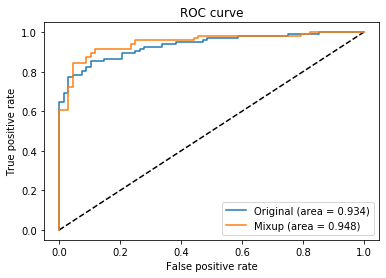

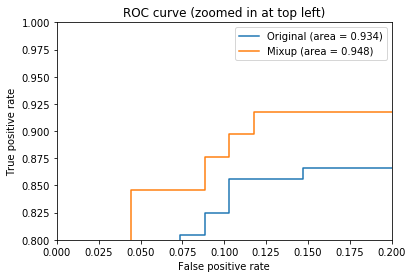

In [0]:
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_o, tpr_keras_o, label='Original (area = {:.3f})'.format(auc_keras_o))
plt.plot(fpr_keras_m, tpr_keras_m, label='Mixup (area = {:.3f})'.format(auc_keras_m))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_o, tpr_keras_o, label='Original (area = {:.3f})'.format(auc_keras_o))
plt.plot(fpr_keras_m, tpr_keras_m, label='Mixup (area = {:.3f})'.format(auc_keras_m))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()